Attempting to fit house prices, using the [Filght fare](https://www.kaggle.com/datasets/yashdharme36/airfare-ml-predicting-flight-fares)

Imports

In [65]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

# import warnings
# warnings.filterwarnings("ignore")

1. Introducing the House prices dataset -- Exploratory Data Analysis (EDA),

In [67]:
dtf = pd.read_csv("./data/data_airfare.csv")

In [77]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]

In [68]:
cols = ["Date_of_journey","Journey_day","Airline","Flight_code","Class","Source","Departure","Total_stops",
        "Arrival","Destination", "Duration_in_hours", "Days_left", "Fare"]
dtf = dtf[cols]

In [69]:
dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


In [70]:
dtf.describe()

,Duration_in_hours,Days_left,Fare
count,452088.000000,452088.000000,452088.000000
mean,12.349222,25.627902,22840.100890
std,7.431478,14.300846,20307.963002
min,0.750000,1.000000,1307.000000
25%,6.583300,13.000000,8762.750000
50%,11.333300,26.000000,13407.000000
75%,16.500000,38.000000,35587.000000
max,43.583300,50.000000,143019.000000


Value Histograms for Categorical Variables

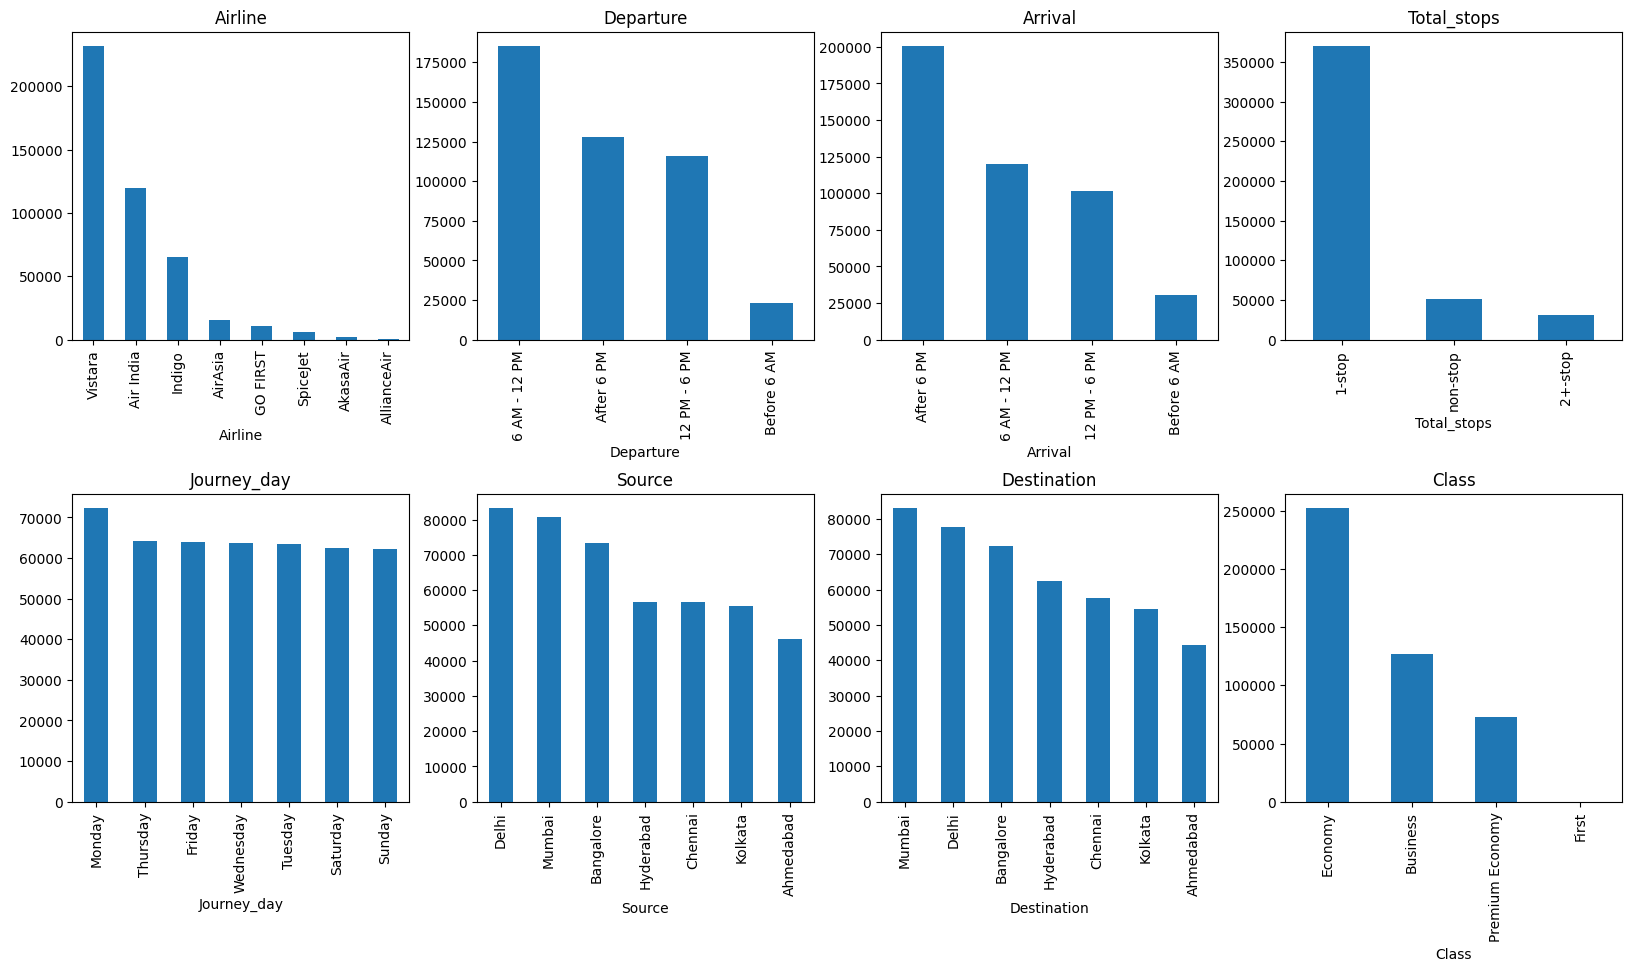

In [85]:
#we will create a histogram for each categorical attribute

# Define the names of categorical columns to remove
columns_to_remove = ["Date_of_journey", "Flight_code"]

# Define the desired order of categorical columns
desired_order = ["Airline", "Departure", "Arrival", "Total_stops", "Journey_day", "Source", "Destination", "Class"]

# Filter categorical columns based on the condition and desired order
categorical_columns_filtered = [c for c in desired_order if c not in columns_to_remove]
                                
n = len(categorical_columns_filtered)
cols = 4
max_bars = 8

rows = (n // cols) + (1 if n % cols != 0 else 0)

#generate a figures grid:
fig, axes = plt.subplots(rows,cols,figsize=(cols*5,rows*5))
fig.subplots_adjust(hspace=0.5)

for i,column in enumerate(categorical_columns_filtered):
    #calculate the current place on the grid
    r=int(i/cols)
    c=i%cols
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(dtf[column].nunique(),max_bars)
    vc = dtf[column].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=column)

Examining the target feature - "SalePrice": Using a histogram, a KDE plot, and a box plot

<Axes: >

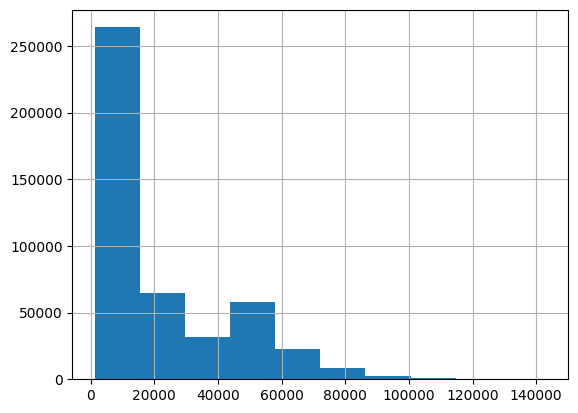

In [72]:
dtf.Fare.hist()

x: the flight fare 
y: the amount of flights of each fare range

<Axes: xlabel='Fare', ylabel='Density'>

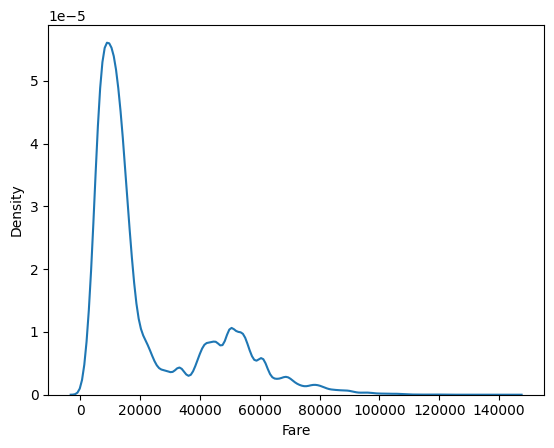

In [74]:
sns.kdeplot(dtf.Fare)

We can see that the data may contains outliers.

Examining outliers

<Axes: xlabel='Fare'>

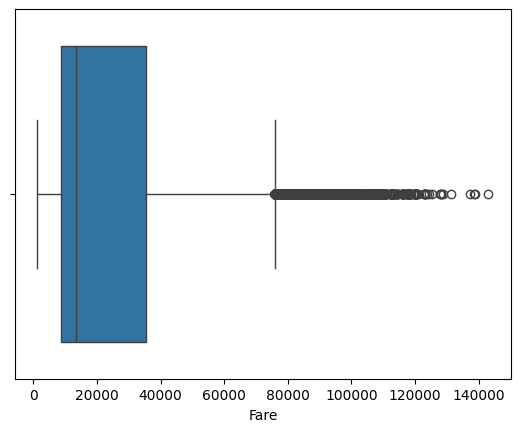

In [76]:
sns.boxplot(dtf.Fare, orient="h")

We suspect that there are outliers around the 140000 fare.